In [1]:
import ROOT, os, sys, glob
from math import *
ROOT.EnableImplicitMT(4); 

Welcome to JupyROOT 6.28/00


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.0.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_JPsiToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root']

In [3]:
rdf = ROOT.RDataFrame("Events","/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root")

In [4]:
rdf.Describe()

Dataframe from TChain Events in file /eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root

Property                Value
--------                -----
Columns in total           34
Columns from defines        0
Event loops run             0
Processing slots            2

Column          Type                            Origin
------          ----                            ------
GenMu_charge    ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_d0        ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_eta       ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_isFromTau ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_isPrompt  ROOT::VecOps::RVec<Int_t>       Dataset
GenMu_mass      ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_phi       ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_pt        ROOT::VecOps::RVec<Float_t>     Dataset
GenMu_vz        ROOT::VecOps::RVec<Float_t>     Dataset
TkMu_GenMuFlav  ROOT::VecOps::RVec<UChar_t>     Dataset
TkMu_GenMuIdx

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


Processed 400000 entries.


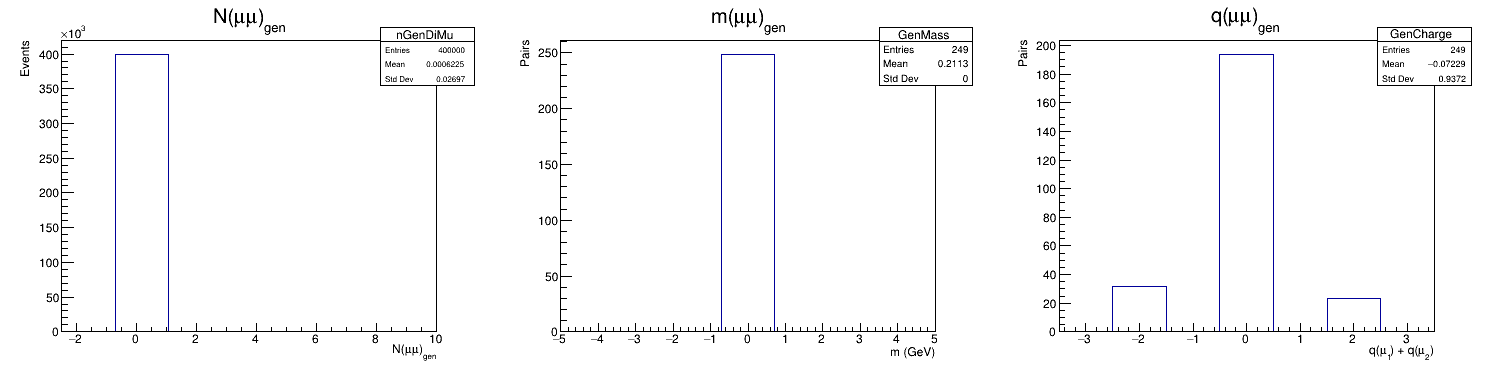

In [5]:
## Now we make pairs of muons
## This needs a bit of inlined C++ code
def makeDimuonPairs(name, rdf):
    ## define 4-vectors in cartesian coordinates, for easier 
    #rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
    ## make indices of all the pairs
    rdf = rdf.Define(f"{name}DiMu_indices", f"""
        ROOT::VecOps::RVec<std::pair<int,int>> ret; 
        for (int i = 0, n = n{name}Mu; i < n; ++i) 
            for (int i2 = i+1; i2 < n; ++i2) 
                ret.emplace_back(i,i2);
        return ret;""")
    
    #Let us impose a selection criteria here
    
    
    ## Make the number of dimuons, for convenience later
    rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
    ## compute the mass, charge
    rdf = rdf.Define(f"{name}DiMu_mass", f"""
        ROOT::RVecF ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(({name}Mu_mass[pair.first]+{name}Mu_mass[pair.second]));
        return ret;""")
    
    
    rdf = rdf.Define(f"{name}DiMu_charge", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
        return ret;""")
    return rdf;


rdf_gendimu = makeDimuonPairs("Gen", rdf)

## Now we make a plot of the number of generated muons and the ones reconstructed by L1T
hNGenPairs = rdf_gendimu.Histo1D(("nGenDiMu","N(#mu#mu)_{gen};N(#mu#mu)_{gen};Events",7,-2.5,10), "nGenDiMu")
hGenPairMass = rdf_gendimu.Histo1D(("GenMass","m(#mu#mu)_{gen};m (GeV);Pairs",7,-5,5), "GenDiMu_mass")
hGenPairCharge = rdf_gendimu.Histo1D(("GenCharge","q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",7,-3.5,3.5), "GenDiMu_charge")
entries = rdf_gendimu.Count().GetValue()
print(f"Processed {entries} entries.")

rdf_gendimu.Describe()
## And plot it
c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNGenPairs,hGenPairMass,hGenPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [6]:
#rdf_gendimu.Display(["GenDiMu_indices"],40000).Print()

In [7]:
## Now select pairs of muons baesed on some conditions
def select_ind(name, rdf):
    
    #Let us impose a selection criteria here
    #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
    rdf = rdf.Define(f"{name}DiMu_good", f"{name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1")
    rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
    rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
    
    return rdf;
rdf_gendisel = select_ind("Gen", rdf_gendimu)
rdf_gendisel.Describe()


Dataframe from TChain Events in file /eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root

Property                Value
--------                -----
Columns in total           40
Columns from defines        6
Event loops run             1
Processing slots            2

Column                  Type                                    Origin
------                  ----                                    ------
GenDiMu_charge          ROOT::VecOps::RVec<int>                 Define
GenDiMu_good            ROOT::VecOps::RVec<int>                 Define
GenDiMu_indices         ROOT::VecOps::RVec<pair<int,int> >      Define
GenDiMu_mass            ROOT::VecOps::RVec<float>               Define
GenMu_charge            ROOT::VecOps::RVec<Int_t>               Dataset
GenMu_d0                ROOT::VecOps::RVec<Float_t>             Dataset
GenMu_eta               ROOT::VecOps::RVec<Float_t>             Dataset
GenMu_isFromTau         ROOT::VecOps::RVe

Processed 400000 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


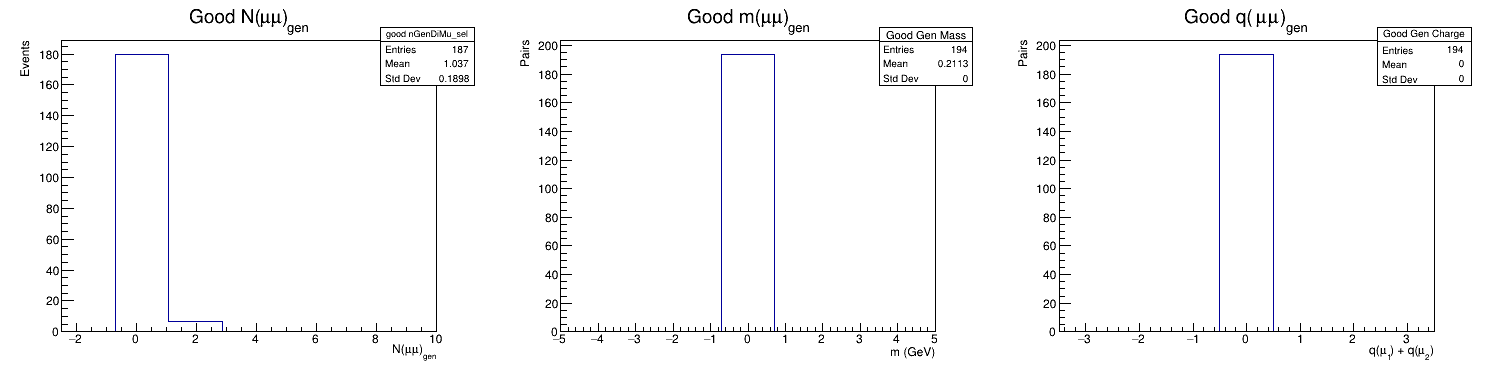

In [8]:
def select_feat(name, rdf):
   
    rdf = rdf.Define(f"n{name}DiMu_sel", f"Good{name}DiMu_indices.size()")
    ## compute the mass, charge
    rdf = rdf.Define(f"{name}DiMu_selMass", f"""
        ROOT::RVecF ret; 
        for (const auto & pair : Good{name}DiMu_indices) 
            ret.emplace_back(({name}Mu_mass[pair.first]+{name}Mu_mass[pair.second]));
        return ret;""")
    
    
    rdf = rdf.Define(f"{name}DiMu_selCharge", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : Good{name}DiMu_indices) 
            ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
        return ret;""")
    return rdf;
rdf_selFeat = select_feat("Gen",rdf_gendisel)
hNGoodGenPairs = rdf_selFeat.Histo1D(("good nGenDiMu_sel","Good N(#mu#mu)_{gen};N(#mu#mu)_{gen};Events",7,-2.5,10), "nGenDiMu_sel")
hGoodGenPairMass = rdf_selFeat.Histo1D(("Good Gen Mass","Good m(#mu#mu)_{gen};m (GeV);Pairs",7,-5,5), "GenDiMu_selMass")
hGoodGenPairCharge = rdf_selFeat.Histo1D(("Good Gen Charge","Good q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",7,-3.5,3.5), "GenDiMu_selCharge")
entries = rdf_gendimu.Count().GetValue()
print(f"Processed {entries} entries.")
#rdf_selFeat.Describe()
#entries = rdf_selFeat.Count().GetValue()

c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNGoodGenPairs,hGoodGenPairMass,hGoodGenPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [10]:
rdf_TkDiMu = makeDimuonPairs("Tk",rdf_selFeat)
rdf_select_Tk = select_ind("Tk",rdf_TkDiMu)
rdf_Tk_selFeat = select_feat("Tk",rdf_select_Tk)
rdf_Tk_selFeat.Describe()

Dataframe from TChain Events in file /eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root

Property                Value
--------                -----
Columns in total           52
Columns from defines       18
Event loops run             2
Processing slots            2

Column                  Type                                    Origin
------                  ----                                    ------
GenDiMu_charge          ROOT::VecOps::RVec<int>                 Define
GenDiMu_good            ROOT::VecOps::RVec<int>                 Define
GenDiMu_indices         ROOT::VecOps::RVec<pair<int,int> >      Define
GenDiMu_mass            ROOT::VecOps::RVec<float>               Define
GenDiMu_selCharge       ROOT::VecOps::RVec<int>                 Define
GenDiMu_selMass         ROOT::VecOps::RVec<float>               Define
GenMu_charge            ROOT::VecOps::RVec<Int_t>               Dataset
GenMu_d0                ROOT::VecOps::RVec<

Processed 62 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


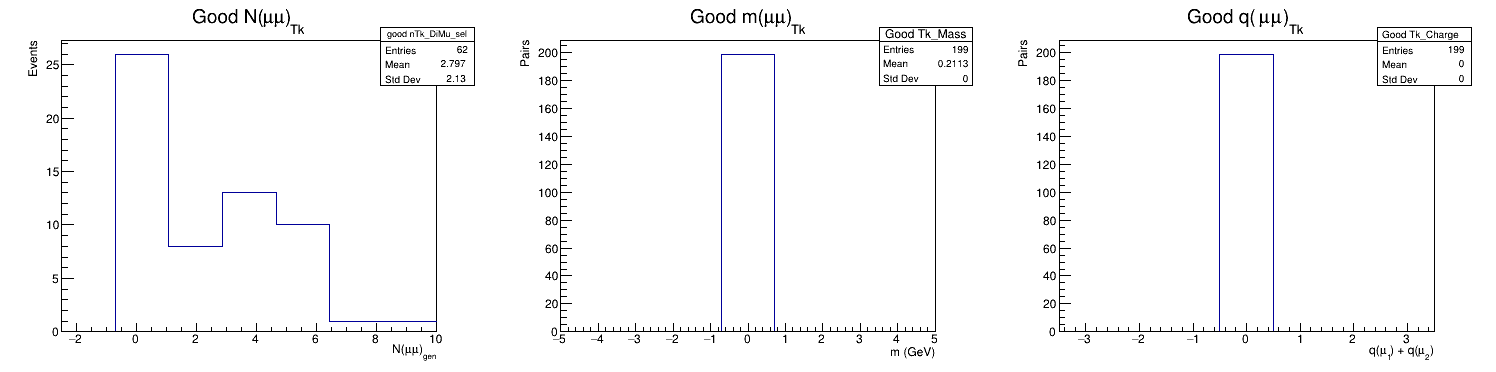

In [15]:
hNGoodTkPairs = rdf_Tk_selFeat.Histo1D(("good nTk_DiMu_sel","Good N(#mu#mu)_{Tk};N(#mu#mu)_{gen};Events",7,-2.5,10), "nTkDiMu_sel")
hGoodTkPairMass = rdf_Tk_selFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",7,-5,5), "TkDiMu_selMass")
hGoodTkPairCharge = rdf_Tk_selFeat.Histo1D(("Good Tk_Charge","Good q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",7,-3.5,3.5), "TkDiMu_selCharge")
entries = rdf_Tk_selFeat.Count().GetValue()
print(f"Processed {entries} entries.")
#rdf_selFeat.Describe()
#entries = rdf_selFeat.Count().GetValue()

c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNGoodTkPairs,hGoodTkPairMass,hGoodTkPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()